# Monte Carlo Project

Purpose of the project is to forecast the short term ranges of Copper futures prices using Monte Carlo methods.

The following code works with both CSV files which are 'HGN20.csv' and 'HGK20.csv'.

## Sections 2 and 3. Data 

User should specify the BIN_INTERVAL (in minutes), contract TICK_SIZE, and current time denoted as NOW. These are the assumptions.

If the user wants to buy (sell), observe the forecast range down (up).

In [ ]:
from matplotlib import pyplot as plt 
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from scipy.stats import gamma
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
BIN_INTERVAL = 5                # in minutes
TICK_SIZE = 0.05
NOW = "2020-08-01 00:00:00"

df = pd.read_csv("HGK20.csv", parse_dates=True, names=['date', 'open', 'high', 'low', 'close', 'volume'])

# Convert the date to a proper 'date and time' and then round down the time
df['date'] = pd.to_datetime(df['date'])
df['bin'] = df['date'] - pd.to_timedelta(df['date'].dt.minute % BIN_INTERVAL, 'm')

df_adj = df.groupby('bin').agg(adj_open = pd.NamedAgg(column='open', aggfunc=lambda x:x[min(x.index)]),
                               adj_high = pd.NamedAgg(column='high', aggfunc=max),
                               adj_low = pd.NamedAgg(column='low', aggfunc=min),
                               adj_close = pd.NamedAgg(column='close', aggfunc=lambda x:x[max(x.index)]),
                               adj_vol = pd.NamedAgg(column='volume', aggfunc=sum))

In [ ]:
df_adj['range'] = round((df_adj['adj_high'] - df_adj['adj_low']) / TICK_SIZE)
df_adj['rangeUp'] = round((df_adj['adj_high'] - df_adj['adj_open']) / TICK_SIZE)
df_adj['rangeDown'] = round((df_adj['adj_open'] - df_adj['adj_low']) / TICK_SIZE)

Let's run preliminary statistics on the dataframe. We see that volume has a large range from 0 up to 5,163 contracts traded per BIN_INTERVAL.

In [ ]:
df_adj.describe()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_adj['adj_vol'])
plt.title('Trading Volume Over Time');

Since this future contract will not be the front month contract for quite some time, it will have very low trading volume. Drop beginning observations (ticks) with volume below 3% of maximum trading volume and plot volume again.

In [ ]:
cutoff = max(df_adj['adj_vol']) * 0.03
length = len(df_adj['adj_vol'])

for i in range(length):
    if df_adj['adj_vol'].iloc[i] >= cutoff:
        first_occurence = i
        break

df_adj = df_adj.drop(df_adj.index[:first_occurence])

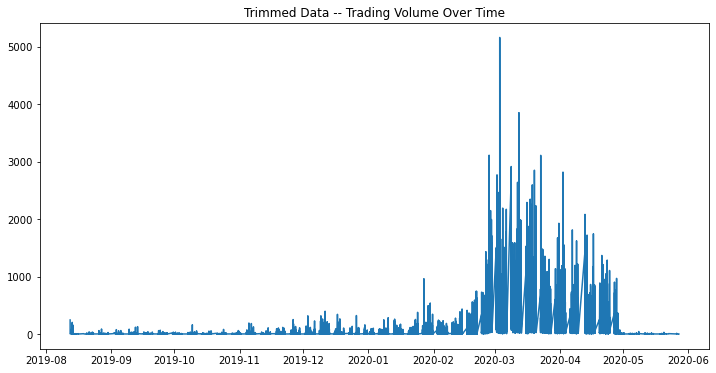

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_adj['adj_vol'])
plt.title('Trimmed Data -- Trading Volume Over Time');

## Section 4. Expected PDF of range, rangeUp, and rangeDown

Let's plot histograms of volume and the 3 types of ranges. Note that the histogram and the frequency dataframe produce the same results (because they represent the same underlying data).

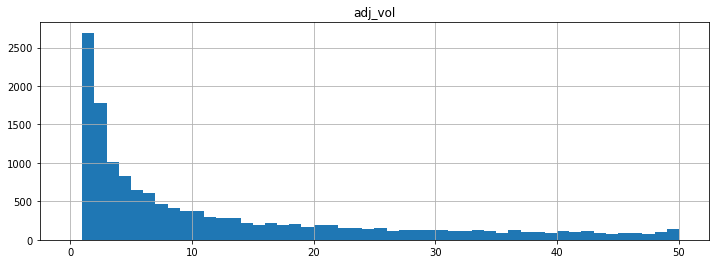

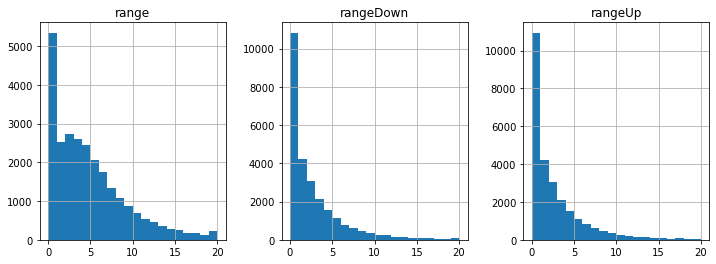

In [ ]:
df_adj.hist(column='adj_vol', range=(0, 50), bins=50, figsize=(12,4))
df_adj.hist(column=['range', 'rangeUp', 'rangeDown'], range=(0, 20), layout=(1,3), bins=20, figsize=(12,4));

In [ ]:
df_freq = pd.DataFrame()
df_freq['range_freq'] = df_adj['range'].value_counts(normalize=True)
df_freq['rangeUp_freq'] = df_adj['rangeUp'].value_counts(normalize=True)
df_freq['rangeDown_freq'] = df_adj['rangeDown'].value_counts(normalize=True)
df_freq.sort_index(inplace=True)
df_freq

,range_freq,rangeUp_freq,rangeDown_freq
0.0,0.200796,0.410791,0.406773
1.0,0.094653,0.158820,0.159383
2.0,0.102989,0.114440,0.115829
3.0,0.097845,0.079297,0.080536
4.0,0.092251,0.056845,0.057708
...,...,...,...
109.0,0.000075,NaN,NaN
110.0,0.000038,NaN,NaN
123.0,0.000038,NaN,NaN
144.0,0.000038,NaN,0.000075


## Section 5. Expected PDF of range, rangeUp, and rangeDn conditioning on state

Let's calculate an exponential moving average for the range column. The exponential moving average places more weight on more recent observations.

In [ ]:
# Create exponential moving average columns
HALF_LIFE = 0.5
df_adj['range_ewm'] = df_adj['range'].ewm(halflife=HALF_LIFE, adjust=False).mean()
df_adj['rangeUp_ewm'] = df_adj['rangeUp'].ewm(halflife=HALF_LIFE, adjust=False).mean()
df_adj['rangeDown_ewm'] = df_adj['rangeDown'].ewm(halflife=HALF_LIFE, adjust=False).mean()

# Get medians
adj_vol_median = df_adj['adj_vol'].median()
rangeEWM_median = df_adj['range_ewm'].median()

### 2 volume x 2 volatility x 2 trend

Assume there are 2 volume states (0 indicating low volume and 1 high volume), 2 more volatility states (also using 0 and 1 as indicator variables), and 2 trend states (up and down). Assume volatility is determined by exponentially weighted range of prices.

In [ ]:
# Create state columns
df_adj['volume_state'] = 0
df_adj['volatility_state'] = 0
df_adj['trend_state'] = 0
df_adj['pct_change'] = df_adj['adj_close'].pct_change()

df_adj.loc[df_adj['adj_vol'] > adj_vol_median, 'volume_state'] = 1
df_adj.loc[df_adj['range_ewm'] > rangeEWM_median, 'volatility_state'] = 1
df_adj.loc[df_adj['pct_change'] > 0, 'trend_state'] = 1

# Delete intermediate calculation column
df_adj = df_adj.drop(columns=['pct_change'])

Our new dataframe is now,

In [ ]:
df_adj

,adj_open,adj_high,adj_low,adj_close,adj_vol,range,rangeUp,rangeDown,range_ewm,rangeUp_ewm,rangeDown_ewm,volume_state,volatility_state,trend_state
bin,,,,,,,,,,,,,,
2019-08-12 12:55:00,261.25,261.30,260.90,260.90,245,8.0,1.0,7.0,8.000000,1.000000,7.000000e+00,1,1,0
2019-08-12 13:00:00,260.95,260.95,260.85,260.85,9,2.0,0.0,2.0,3.500000,0.250000,3.250000e+00,0,0,0
2019-08-12 14:55:00,260.50,260.50,260.50,260.50,2,0.0,0.0,0.0,0.875000,0.062500,8.125000e-01,0,0,0
2019-08-13 01:45:00,260.70,260.70,260.65,260.65,30,1.0,0.0,1.0,0.968750,0.015625,9.531250e-01,0,0,1
2019-08-13 01:50:00,260.65,260.80,260.55,260.80,79,5.0,3.0,2.0,3.992188,2.253906,1.738281e+00,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27 07:30:00,242.05,242.05,242.05,242.05,1,0.0,0.0,0.0,0.002930,0.002930,3.955271e-16,0,0,0
2020-05-27 08:10:00,241.25,241.25,241.25,241.25,1,0.0,0.0,0.0,0.000733,0.000733,9.888178e-17,0,0,0
2020-05-27 09:10:00,238.70,238.70,238.70,238.70,3,0.0,0.0,0.0,0.000183,0.000183,2.472044e-17,0,0,0


Let's plot the regimes over time.

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12,8))
axes[0].plot(df_adj['volume_state'])
axes[1].plot(df_adj['volatility_state'])
axes[2].plot(df_adj['trend_state']);

The following is a frequency table for the range conditioning on volume, volatility, and trend states.

In [ ]:
pd.crosstab(df_adj['range'], [df_adj['volume_state'], df_adj['volatility_state'], df_adj['trend_state']], margins=True, margins_name='Total')

Same frequency table normalized.

In [ ]:
pd.crosstab(df_adj['range'], [df_adj['volume_state'], df_adj['volatility_state'], df_adj['trend_state']], normalize=True)

### PDF and CDF by Regime

#### Range PDF and CDF by Volume (Low and High)

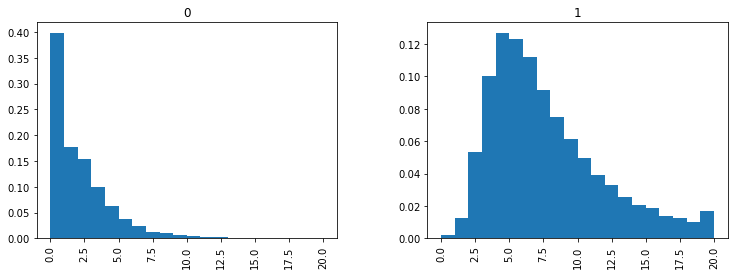

In [ ]:
df_adj.hist(column='range', by='volume_state', range=(0, 20), figsize=(12, 4), bins=20, density=True);

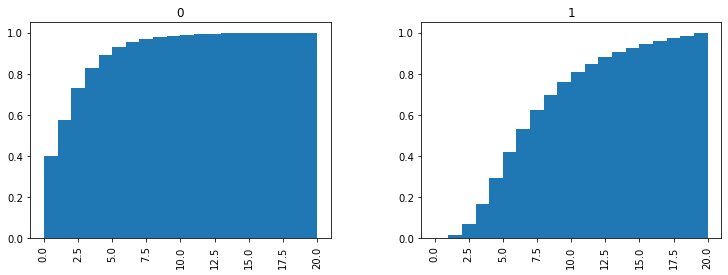

In [ ]:
df_adj.hist(column='range', by='volume_state', range=(0, 20), figsize=(12, 4), bins=20, cumulative=True, density=True);

#### Range PDF and CDF by Volatility (Low and High)

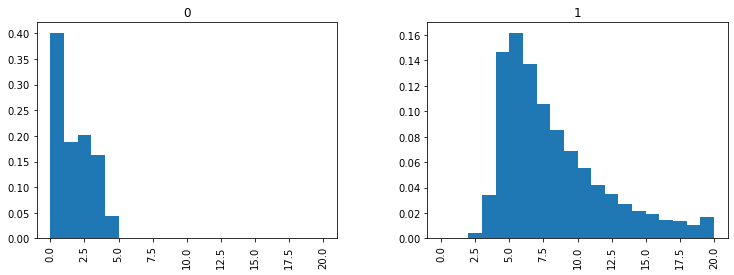

In [ ]:
df_adj.hist(column='range', by='volatility_state', range=(0, 20), figsize=(12, 4), bins=20, density=True);

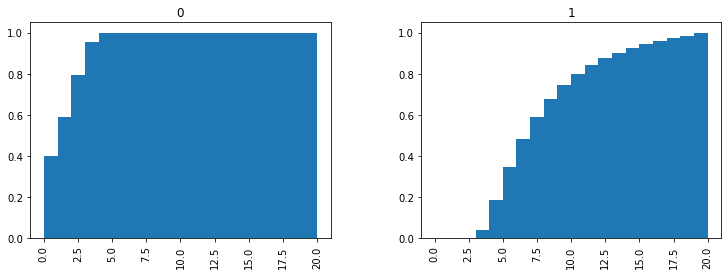

In [ ]:
df_adj.hist(column='range', by='volatility_state', range=(0, 20), figsize=(12, 4), bins=20, cumulative=True, density=True);

#### Range PDF and CDF by Trend (Low and High)

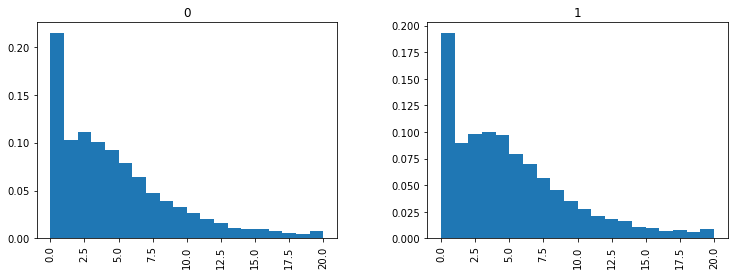

In [ ]:
df_adj.hist(column='range', by='trend_state', range=(0, 20), figsize=(12, 4), bins=20, density=True);

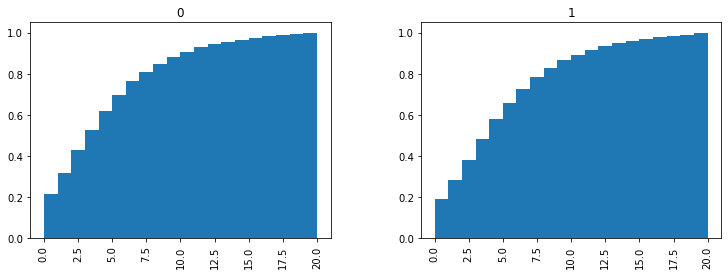

In [ ]:
df_adj.hist(column='range', by='trend_state', range=(0, 20), figsize=(12, 4), bins=20, density=True, cumulative=True);

#### Range PDF and CDF During High Volume and Low Volatility

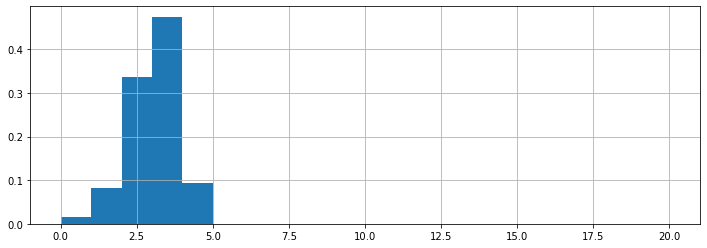

In [ ]:
regime100 = df_adj.loc[(df_adj['volume_state'] == 1) 
                       & (df_adj['volatility_state'] == 0)
                       & (df_adj['trend_state'] == 0), 'range']

regime100.hist(range=(0, 20), figsize=(12, 4), bins=20, density=True);

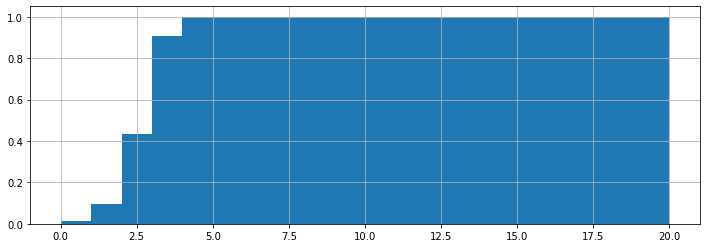

In [ ]:
regime100.hist(range=(0, 20), figsize=(12, 4), bins=20, density=True, cumulative=True);

#### Range PDF and CDF During Low Volume and High Volatility

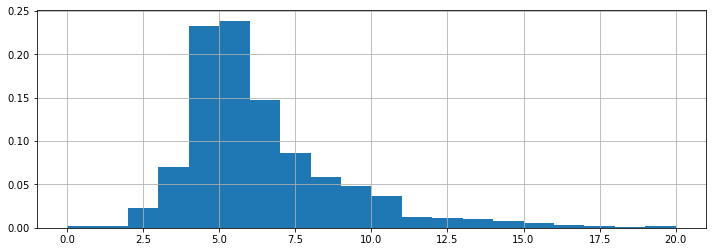

In [ ]:
regime010 = df_adj.loc[(df_adj['volume_state'] == 0) 
                       & (df_adj['volatility_state'] == 1)
                       & (df_adj['trend_state'] == 0), 'range']

regime010.hist(range=(0, 20), figsize=(12, 4), bins=20, density=True);

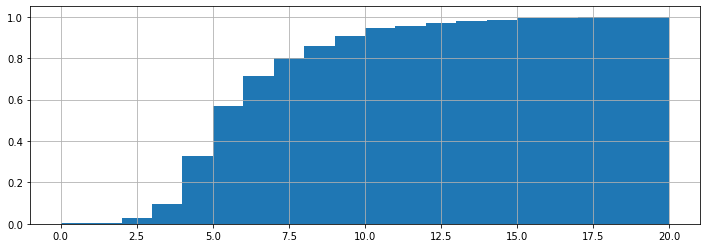

In [ ]:
regime010.hist(range=(0, 20), figsize=(12, 4), bins=20, density=True, cumulative=True);

#### Range PDF and CDF During High Volume and High Volatility

The largest expected range should occur in high volume and high volatility regimes based on prior graphs. We can confirm this visually below.

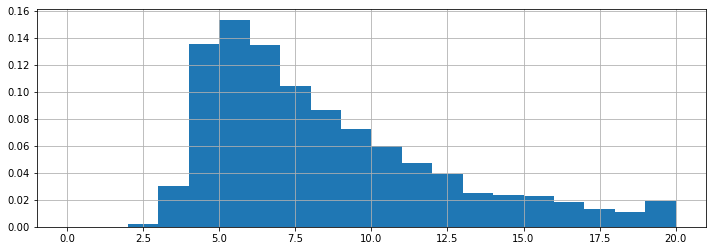

In [ ]:
regime110 = df_adj.loc[(df_adj['volume_state'] == 1) 
                       & (df_adj['volatility_state'] == 1)
                       & (df_adj['trend_state'] == 0), 'range']

regime110.hist(range=(0, 20), figsize=(12, 4), bins=20, density=True);

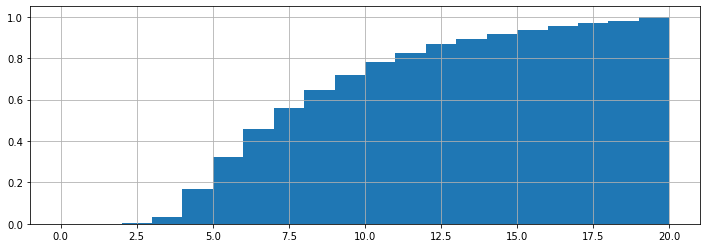

In [ ]:
regime110.hist(range=(0, 20), figsize=(12, 4), bins=20, density=True, cumulative=True);

### Test Model Accuracy

From the figures below, we can see that volume and volatility are both good predictors of the trading range. However, the trend state (whether prices are increasing or decreasing) is a poor predictor.

#### Volume as a Predictor of Trading Range

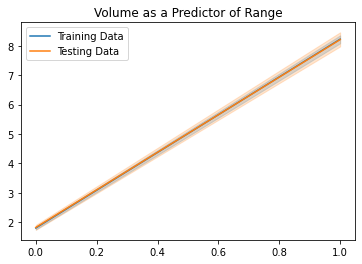

In [ ]:
X, y = df_adj[['volume_state', 'volatility_state', 'trend_state']], df_adj['range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

fig, ax = plt.subplots()
sns.lineplot(x=X_train.volume_state.values, y=y_train.values, label='Training Data')
sns.lineplot(x=X_test.volume_state.values, y=y_test.values, label='Testing Data')
ax.set(title='Volume as a Predictor of Range')
ax.legend();

#### Volatility as a Predictor of Trading Range

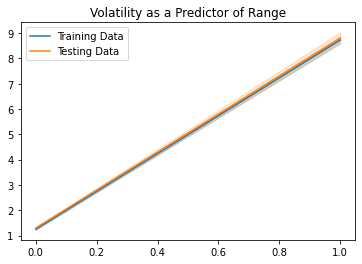

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=X_train.volatility_state.values, y=y_train.values, label='Training Data')
sns.lineplot(x=X_test.volatility_state.values, y=y_test.values, label='Testing Data')
ax.set(title='Volatility as a Predictor of Range')
ax.legend();

#### Trend as a Predictor of Trading Range

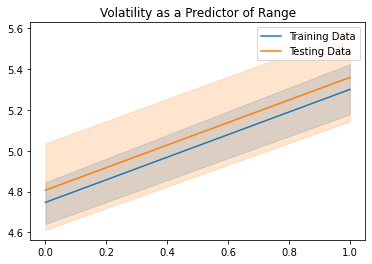

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=X_train.trend_state.values, y=y_train.values, label='Training Data')
sns.lineplot(x=X_test.trend_state.values, y=y_test.values, label='Testing Data')
ax.set(title='Volatility as a Predictor of Range')
ax.legend();

### 2 volume x 3 volatility x 2 trend

Let's repeat the above analysis, this time assuming there are 3 volatility regimes instead of 2.

In [ ]:
# Get volatility quantiles
volatility1 = df_adj['range_ewm'].quantile(0.33)
volatility2 = df_adj['range_ewm'].quantile(0.66)

# Update volatility states
df_adj.loc[df_adj['range_ewm'] > volatility1, 'volatility_state'] = 1
df_adj.loc[df_adj['range_ewm'] > volatility2, 'volatility_state'] = 2

Here is the normalized frequency table, this time with 3 volatility regimes.

In [ ]:
pd.crosstab(df_adj['range'], [df_adj['volume_state'], df_adj['volatility_state'], df_adj['trend_state']], normalize=True)

volume_state             0                                                    \
volatility_state         0                   1                   2             
trend_state              0         1         0         1         0         1   
range                                                                          
0.0               0.116693  0.081287  0.000976  0.000713  0.000000  0.000000   
1.0               0.050199  0.033679  0.002516  0.002178  0.000038  0.000000   
2.0               0.020688  0.016408  0.024292  0.016145  0.000000  0.000000   
3.0               0.000000  0.000000  0.026583  0.023541  0.000038  0.000000   
4.0               0.000000  0.000000  0.016370  0.014455  0.000563  0.000375   
...                    ...       ...       ...       ...       ...       ...   
109.0             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
110.0             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
123.0             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
144.0             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147.0             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

volume_state             1                                                    
volatility_state         0                   1                   2            
trend_state              0         1         0         1         0         1  
range                                                                         
0.0               0.000638  0.000451  0.000038  0.000000  0.000000  0.000000  
1.0               0.003529  0.002027  0.000300  0.000188  0.000000  0.000000  
2.0               0.002703  0.001690  0.013254  0.007772  0.000038  0.000000  
3.0               0.000000  0.000000  0.028648  0.018923  0.000075  0.000038  
4.0               0.000000  0.000000  0.032365  0.025832  0.001389  0.000901  
...                    ...       ...       ...       ...       ...       ...  
109.0             0.000000  0.000000  0.000000  0.000000  0.000075  0.000000  
110.0             0.000000  0.000000  0.000000  0.000000  0.000038  0.000000  
123.0             0.000000  0.000000  0.000000  0.000000  0.000038  0.000000  
144.0             0.000000  0.000000  0.000000  0.000000  0.000038  0.000000  
147.0             0.000000  0.000000  0.000000  0.000000  0.000038  0.000000  

[73 rows x 12 columns]

Let's plot the trading range conditioned on the volatility regime.

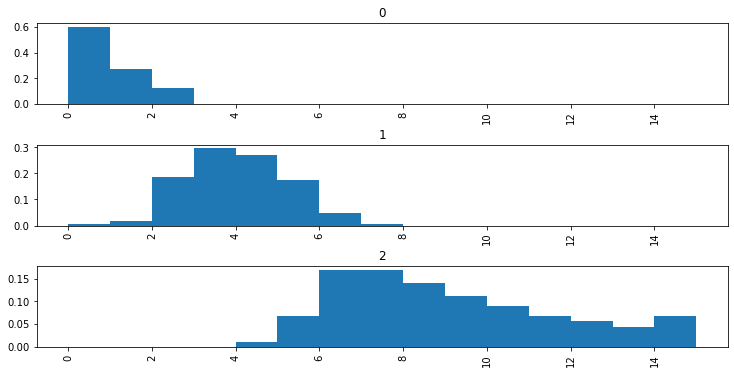

In [ ]:
df_adj.hist(column='range', by='volatility_state', range=(0, 15), figsize=(12, 6), bins=15, layout=(3,1), 
           density=True);

## Section 6. Bayesian Approach & Markov Chain Monte Carlo (MCMC)

Prior distribution: Gamma <br>
Data: Poisson <br>
Posterior distribution: Gamma

<IPython.core.display.Javascript object>


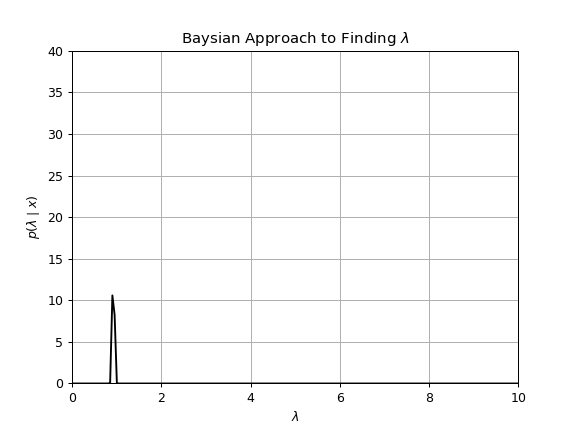

In [ ]:
X_AXIS_MAX = 10

y_array = df_adj.iloc[:, 5].values

class module_exp():
    def __init__(self, ax):
        self.x = np.linspace(0, X_AXIS_MAX, 200)
        self.line, = ax.plot([], [], 'k-')
        self.ax = ax
        self.ax.set_xlim(0, X_AXIS_MAX)
        self.ax.set_ylim(0, 40)
        self.ax.grid(True)
        self.ax.set_xlabel('$\\lambda$')
        self.ax.set_ylabel('$p(\\lambda \mid x)$')
        self.ax.set_title('Baysian Approach to Finding $\\lambda$')
        
    def init(self):
        self.alpha0 = 1
        self.beta0 = 1
        self.lam = 1
        self.line.set_data(self.x, gamma.pdf(self.x, self.alpha0, scale=1/self.beta0))
        return self.line
    
    def __call__(self, i):
        if i == 0:
            return self.init()
        z = y_array[i]
        # posterior
        alpha = self.alpha0 + 1
        beta = self.beta0 + z
        y = gamma.pdf(self.x, alpha, scale=1/beta)
        # update prior
        self.alpha0 = alpha
        self.beta0 = beta
        self.lam = self.alpha0 / self.beta0
        self.line.set_data(self.x, y)
        return self.line

num_obs = len(y_array)
%matplotlib notebook

fig, ax = plt.subplots()
ud = module_exp(ax)
anim = FuncAnimation(fig, ud, frames=np.arange(num_obs), init_func=ud.init, interval=1, blit=True, repeat=False)
plt.show()

We can rerun the above analysis conditioning on the regime state. First, let's choose the regimes to condition on.

In [ ]:
volume_regime = 0
volatility_regime = 0
trend_regime = 0

df_adj_regime = df_adj[(df_adj['volume_state'] == volume_regime) 
                       & (df_adj['volatility_state'] == volatility_regime)
                       & (df_adj['trend_state'] == trend_regime)]

<IPython.core.display.Javascript object>


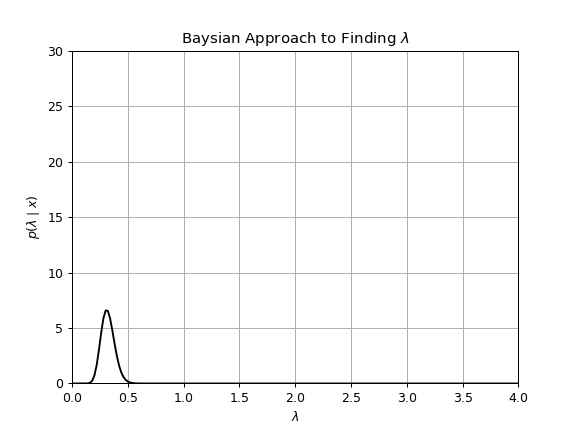

In [ ]:
X_AXIS_MAX = 4

class module_exp():
    def __init__(self, ax):
        self.x = np.linspace(0, X_AXIS_MAX, 200)
        self.line, = ax.plot([], [], 'k-')
        self.ax = ax
        self.ax.set_xlim(0, X_AXIS_MAX)
        self.ax.set_ylim(0, 30)
        self.ax.grid(True)
        self.ax.set_xlabel('$\\lambda$')
        self.ax.set_ylabel('$p(\\lambda \mid x)$')
        self.ax.set_title('Baysian Approach to Finding $\\lambda$')
        
    def init(self):
        self.alpha0 = 1
        self.beta0 = 1
        self.lam = 1
        self.line.set_data(self.x, gamma.pdf(self.x, self.alpha0, scale=1/self.beta0))
        return self.line
    
    def __call__(self, i):
        if i == 0:
            return self.init()
        # df_adj['adj_vol'].iloc[i]
        z = df_adj_regime['adj_vol'][i]
        # posterior
        alpha = self.alpha0 + 1
        beta = self.beta0 + z
        y = gamma.pdf(self.x, alpha, scale=1/beta)
        # update prior
        self.alpha0 = alpha
        self.beta0 = beta
        self.lam = self.alpha0 / self.beta0
        self.line.set_data(self.x, y)
        return self.line

num_obs = len(df_adj_regime)
%matplotlib notebook

fig, ax = plt.subplots()
ud = module_exp(ax)
anim = FuncAnimation(fig, ud, frames=np.arange(num_obs), init_func=ud.init, interval=200, blit=True, repeat=False)
plt.show()